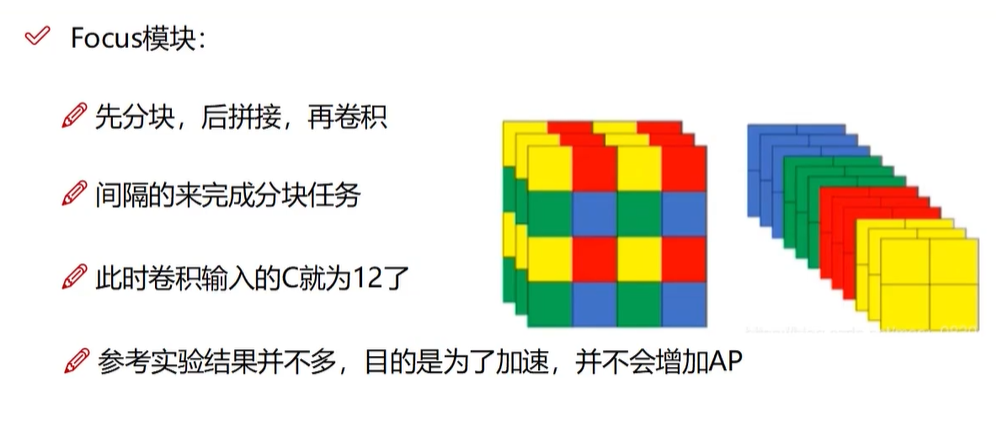

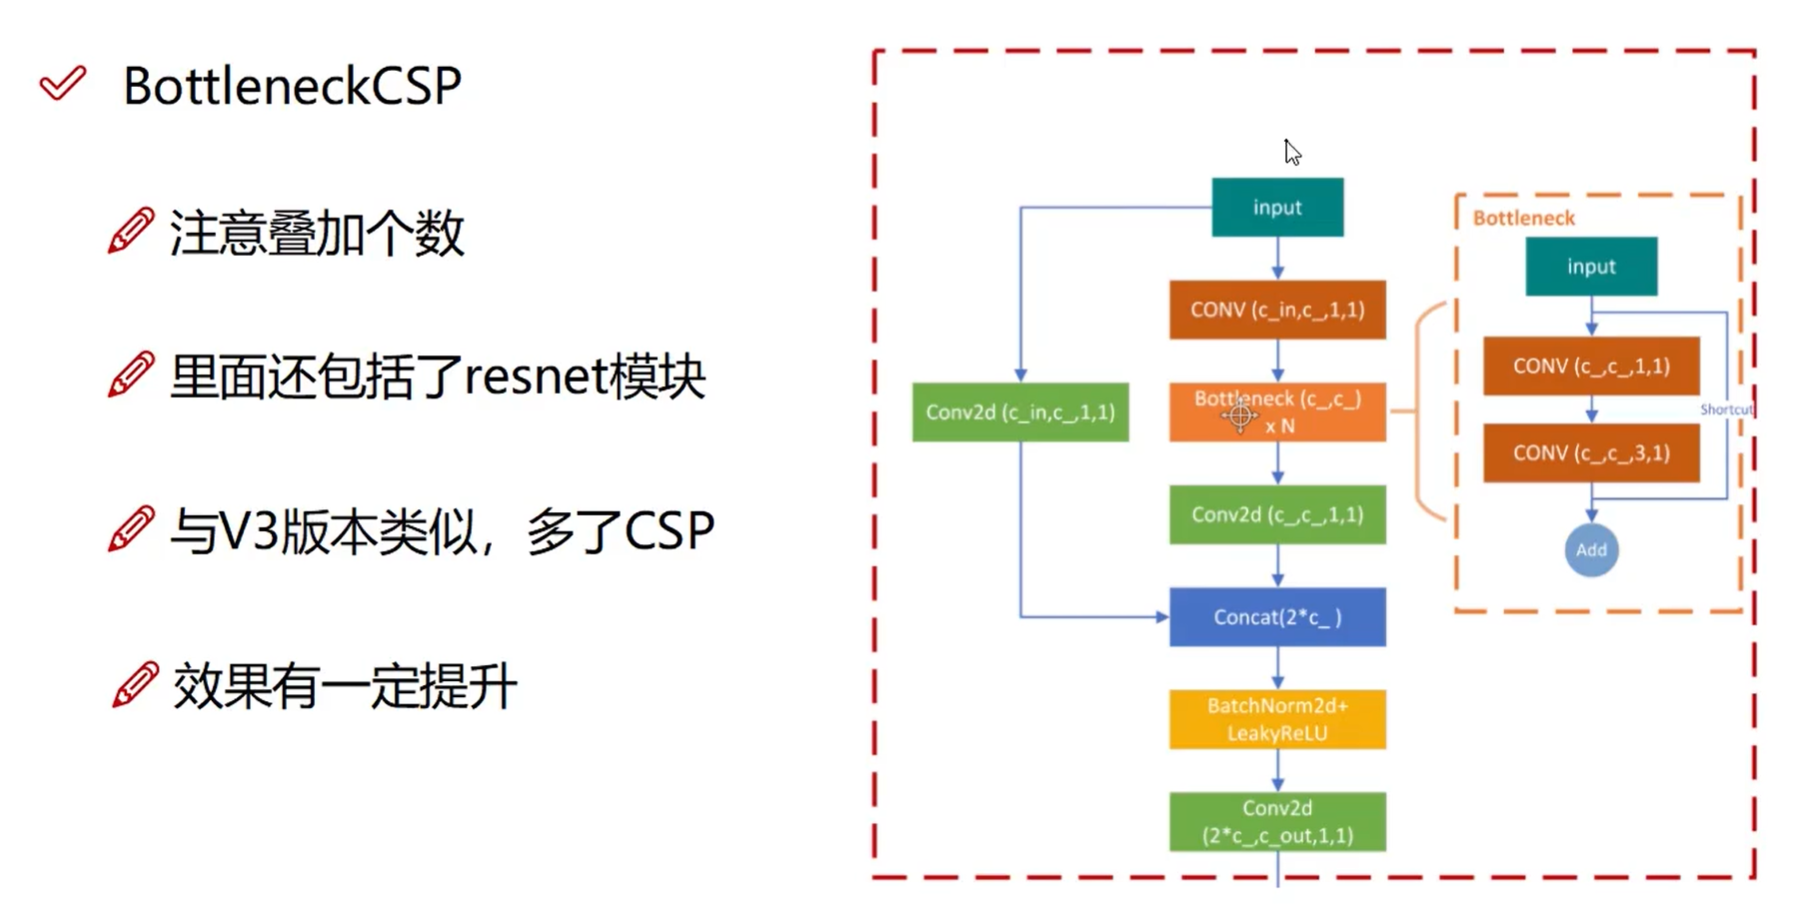

在YOLOv5中，depth_multiple和width_multiple是两个用于调整模型大小和复杂度的超参数。这些参数对于模型的深度（层数）和宽度（通道数）进行缩放，以此来控制模型的大小和性能。它们在模型配置文件中被定义，用于定制不同大小（和相应性能）的YOLOv5模型，以适应不同的应用需求和硬件能力。

在YOLOv5中，SPPF是指“Spatial Pyramid Pooling-Fast”层，它是空间金字塔池化（Spatial Pyramid Pooling, SPP）的一种变体，专为提高效率和速度而设计。SPPF在神经网络中用于提高模型对输入图像尺寸变化的鲁棒性，并帮助网络捕获不同尺度的特征。

空间金字塔池化（SPP）本身是一种神经网络层，用于在卷积神经网络（CNN）中处理不同尺寸的输入。传统的卷积网络通常需要固定大小的输入，但SPP层允许网络处理任意大小的输入图像。它通过在多个尺度上对特征图进行池化（如使用不同尺寸的池化窗口），然后将这些池化后的特征拼接起来，从而生成固定长度的输出向量。这样，不论输入图像的尺寸如何变化，SPP层都能输出一致大小的特征表示，使得网络可以处理不同尺寸的输入。

SPPF是对SPP的一个优化版本，它在提取多尺度特征的同时，专注于减少计算复杂度和提高处理速度。YOLOv5中采用SPPF层，是为了在保持模型对不同尺寸输入的适应性的同时，提高模型的整体效率和速度。这对于实时目标检测任务尤为重要，因为这类任务通常需要快速且准确地处理不同大小和尺度的图像。通过使用SPPF层，YOLOv5能够有效地平衡检测性能和计算效率

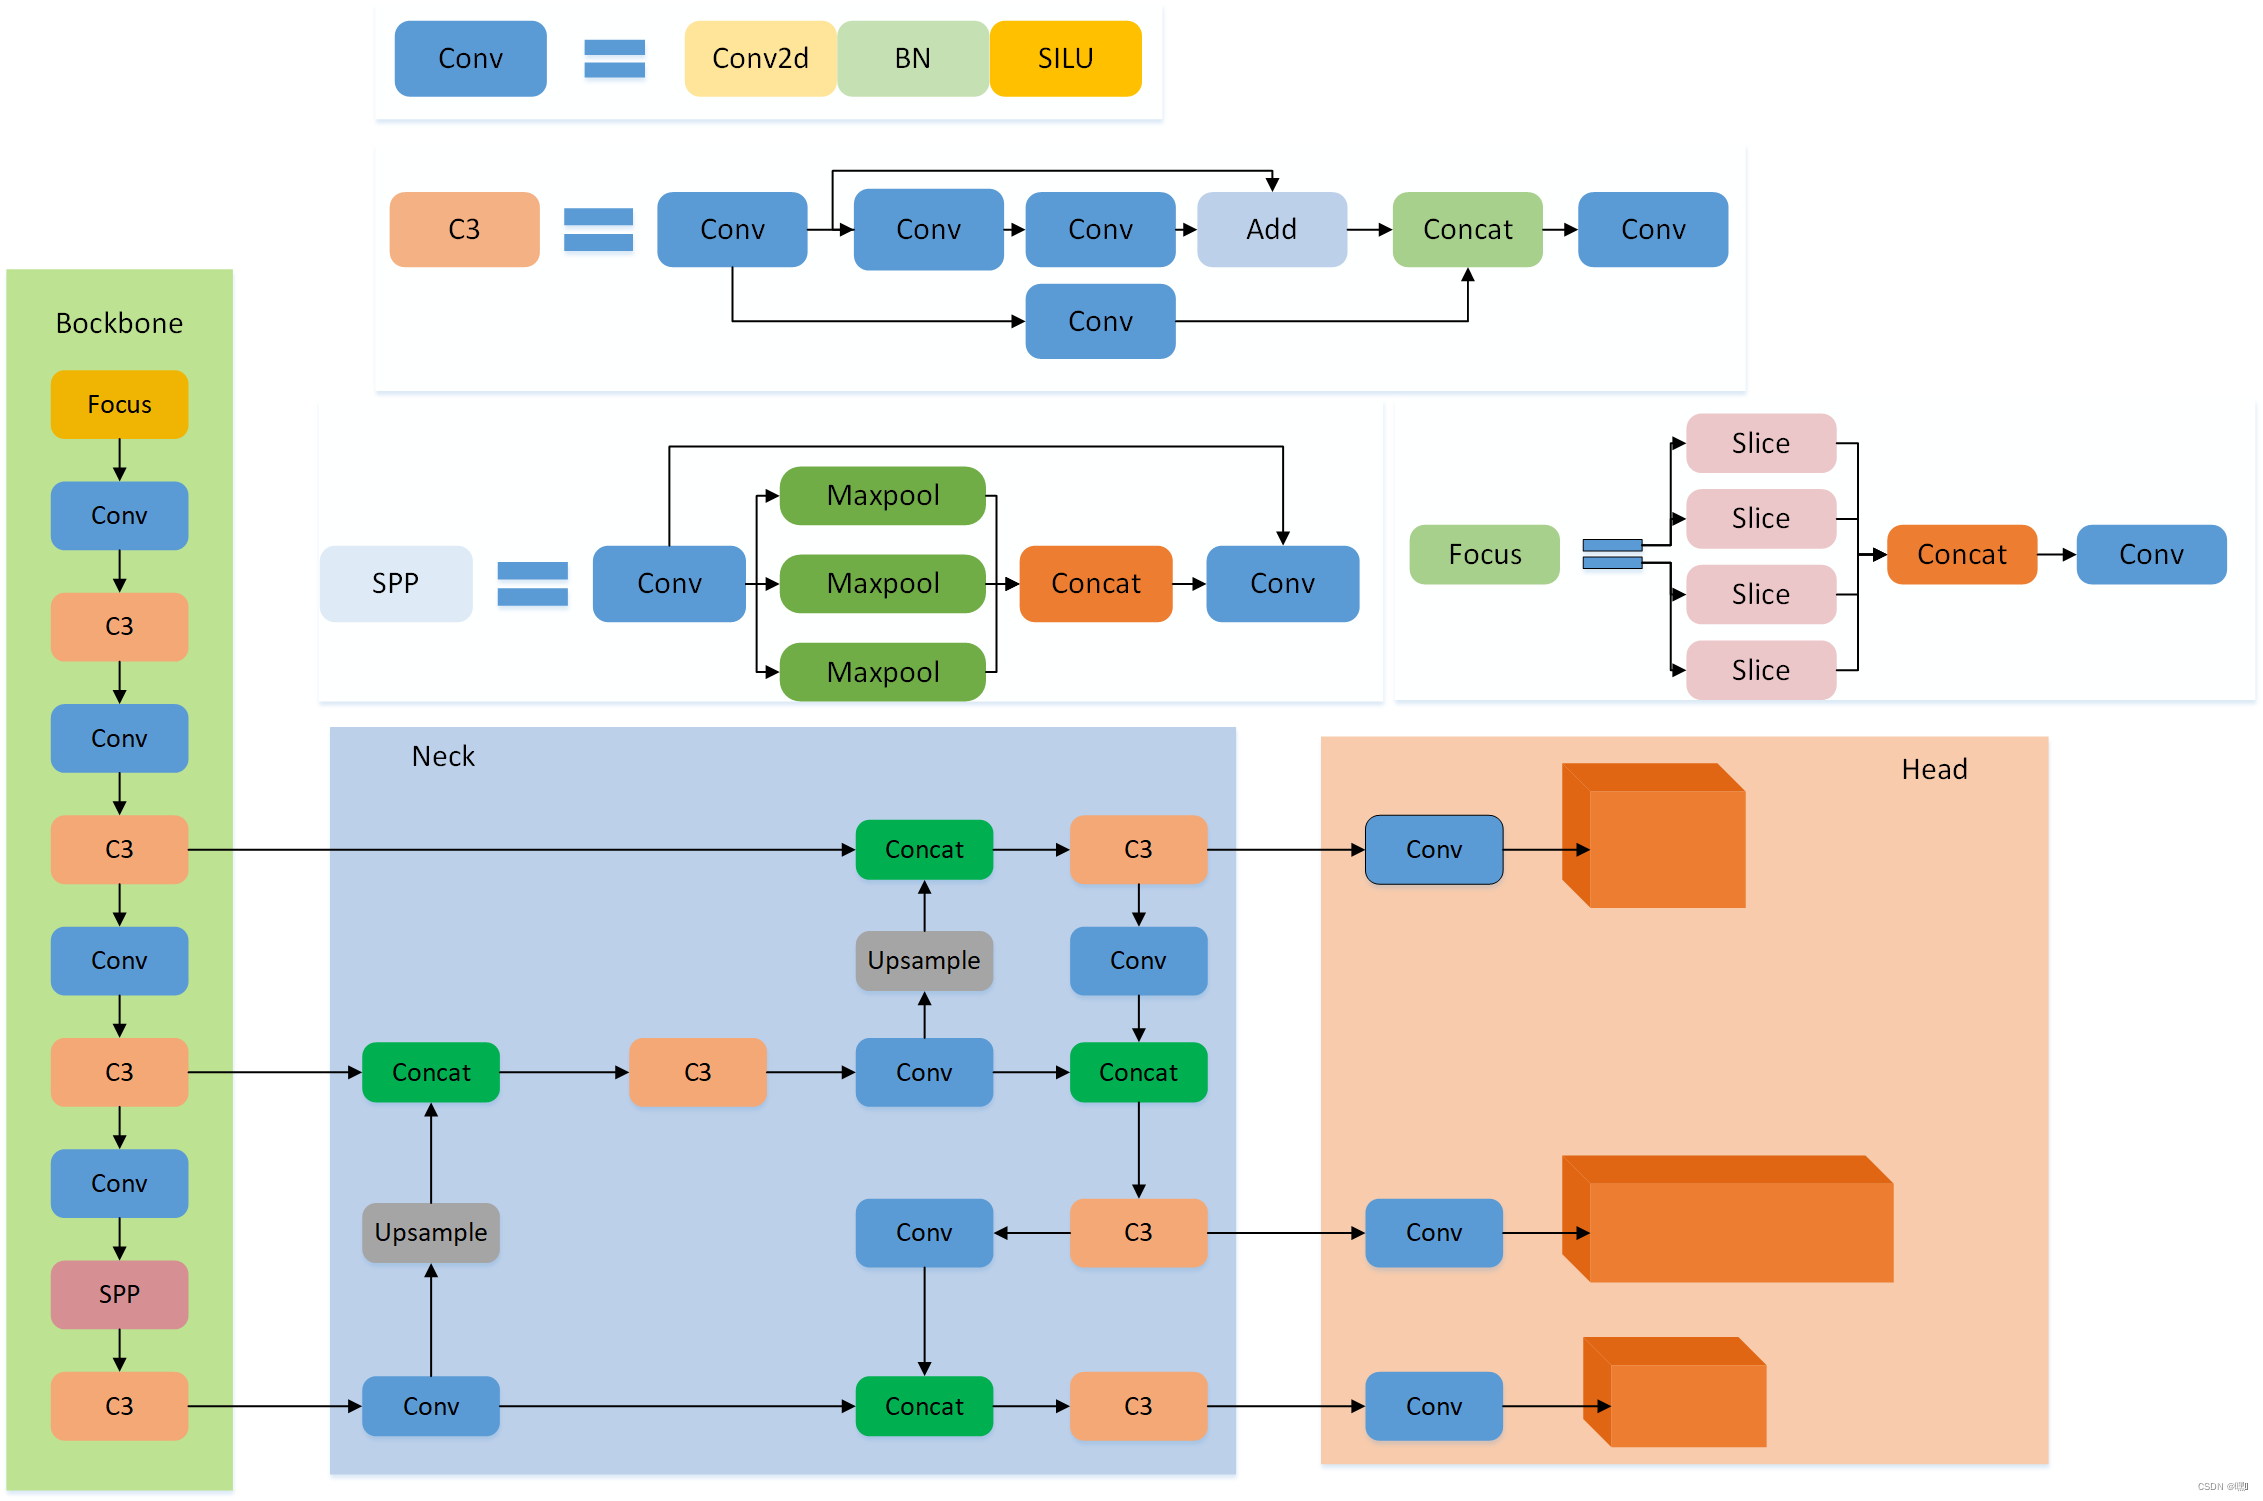

YOLOv5是Glenn Jocher等人研发，它是Ultralytics公司的开源项目。YOLOv5根据参数量分为了n、s、m、l、x五种类型，其参数量依次上升，当然了其效果也是越来越好。

YOLOv5_v6是对三个尺度的特征图进行目标检测的，即large（大）、medium（中）、small（小）三种。

1）**准备工作（Input中进行）**：图片需要经过数据增强（尤其是Mosaic数据增强），并且初始化一组anchor预设（YOLOv5_v6针对不同参数量的模型给出了不同的通用预设）。

2）**特征提取（Backbone中进行）**：使用了Conv、C3、SPPF基本结构对输入图片进行特征提取。Conv用于对输入进行下采样（共进行了5次下采样）；C3用于对输入进行特征提取、融合，丰富特征的语义信息，在这个过程中使用了Boottleneck减少参数量和计算量、借鉴CSPNet思想增强CNN学习能力；SPPF利用池化、特征融合的方式丰富特征的语义信息，使得最深层的特征图拥有极丰富的语义信息。

3）**加工特征（Neck中进行）**：对要进行目标检测的三种尺度的特征图融合浅层特征（浅层特征有利于检测）。v6借鉴了PANet，对提取的特征图融合浅层特征，使得特征图既具有丰富的语义信息又具有物体准确的位置信息。

4）**预测目标（Head中进行）**：对加工后的特征图进行预测，根据损失函数（Classificition Loss和Bounding Box Regeression Loss）和优化器优化参数权重。

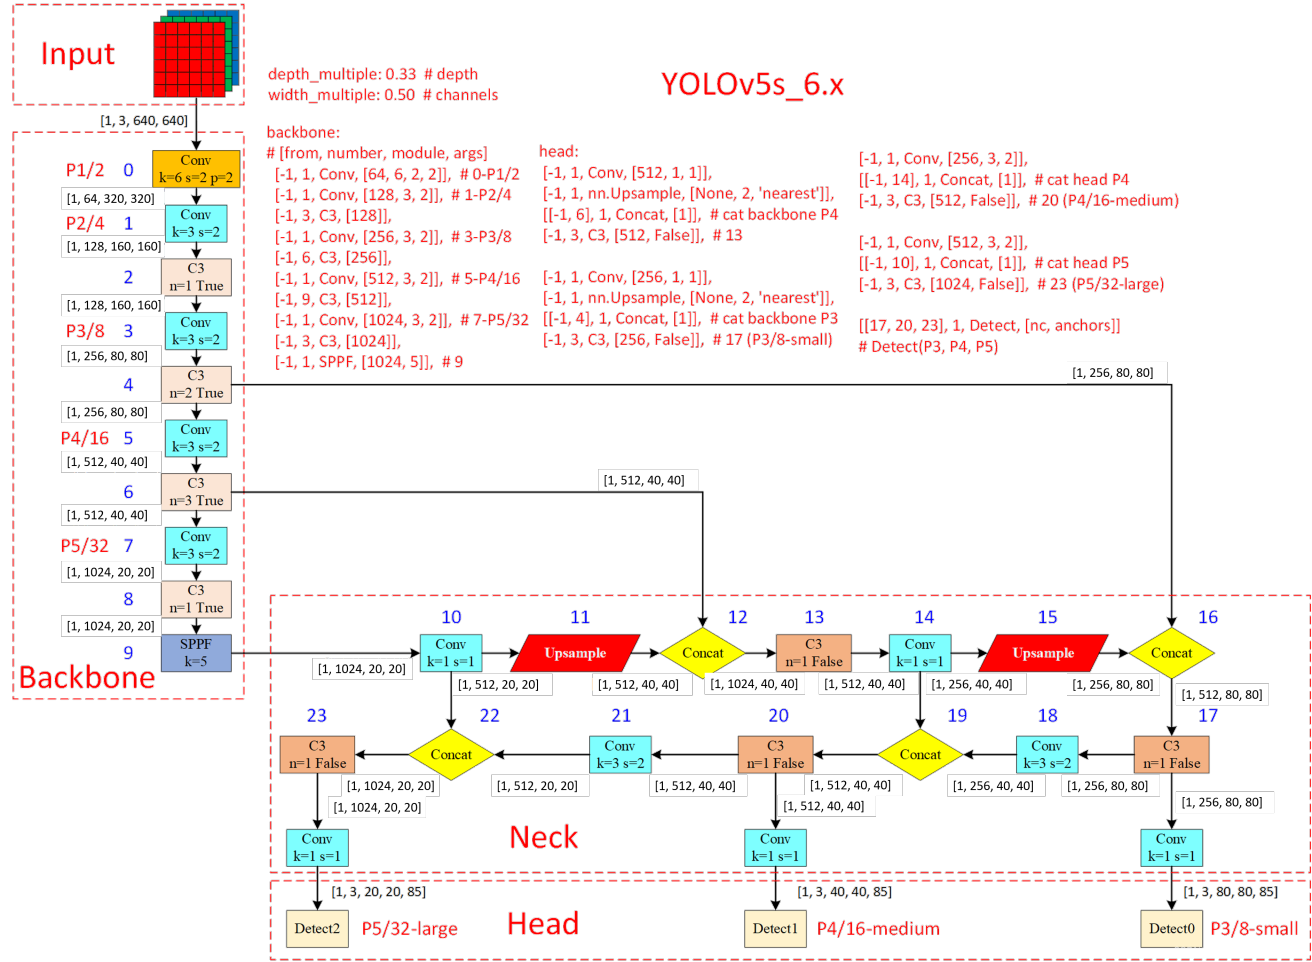

**anchor（锚框）**就是在图像上预设好的不同大小，不同长宽比的参照框。anchor是由Faster-RCNN提出的，anchor解决了scale和aspect ratio变化范围大的问题，即将单元格的预测框空间划分为了几个子空间，降低模型学习难度。在YOLOv5中，输入图片的尺寸是640640，经过32倍、16倍、8倍下采样，会产生20*20、40*40、80*80大小的特征图（也就是网格尺寸），特征图的每个像素（该像素对应的视野域大小就是网格中的单元格大小）设置3个anchor，因此v5一共有 (20*20+40*40+80*80)3=25200个anchor。

那么，anchor是如何对输出的预测框产生影响的呢？借助神经网络强大的拟合能力，直接让神经网络**输出每个anchor是否包含（或者说与物体有较大重叠，也就是IoU较大）物体，以及被检测物体相对本anchor的中心点偏移以及长宽比例**。因为anchor的位置都是固定的，所以就可以很容易的换算出来实际物体的位置。以下图中的小猫为例，**红色的anchor就以99%的概率认为它是一只猫，并同时给出了猫的实际位置相对于该anchor的偏移量**，这样，我们将输出解码后就得到了实际猫的位置，如果它能通过NMS（非最大抑制）筛选，它就能顺利的输出来。但是，绿色的anchor就认为它是猫的概率就很小，紫色的anchor虽然与猫有重叠，但是概率只有26%。

## 前置知识

### Bottleneck

Bottleneck结构是为了减少参数量和计算量而设计的，其包括三个卷积层：两个11卷积层和一个33卷积层，其结构如下图左（图右是等效的33卷积层）所示：

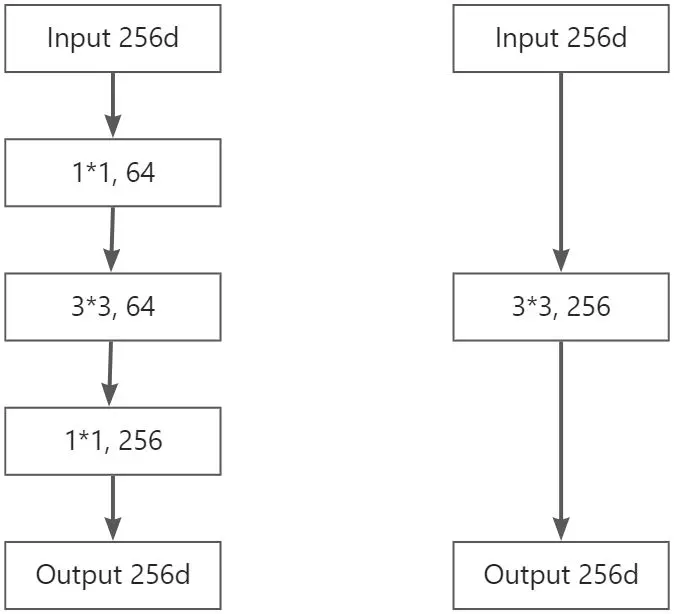

假设Input是[1, 256, 10, 10]，则普通卷积的参数量（params）：256*3*3*256+256=590, 080（最后一个256是BN层参数，不考虑bias）
普通卷积的计算量（FLOPs）：256*3*3*256*10*10=58,982,400（不考虑bias）
Bottleneck结构的参数量（params）：(256*1*1*64+64)+(64*3*3*64+64)+(64*1*1*256+256)=70, 016（最后一个256是BN层参数，不考虑bias）
Bottleneck结构的计算量（FLOPs）：256*1*1*64*10*10+64*3*3*64*10*10+64*1*1*256*10*10=6,963,200（不考虑bias）
可以看到Bottleneck结构减少了的参数量和计算量十分明显。

### CSPNet（Cross Stage Partial Network）

CSPNe是一种增强CNN学习能力的跨阶段局部网络。CSPNet全称是Cross Stage Partial Network，主要从网络结构设计的角度来解决以往工作在推理过程中需要很大计算量的问题，其**能够在降低20%计算量的情况下保持甚至提高CNN的能力**。作者认为推理计算过高的问题是由于网络优化中的**梯度信息重复**导致的，因此CSPNet通过将梯度的变化**从头到尾地集成到特征图**中，在减少了计算量的同时可以保证准确率。需要指出的是CSPNet是一种处理思想，它可以与ResNet、DenseNet、HarNet等分类网络和YOLO等目标检测网络结合。下图展示了CSPNet与不同网络的backbone结合后的效果，可以看出计算量大幅下降、准确率保持不变或提升。
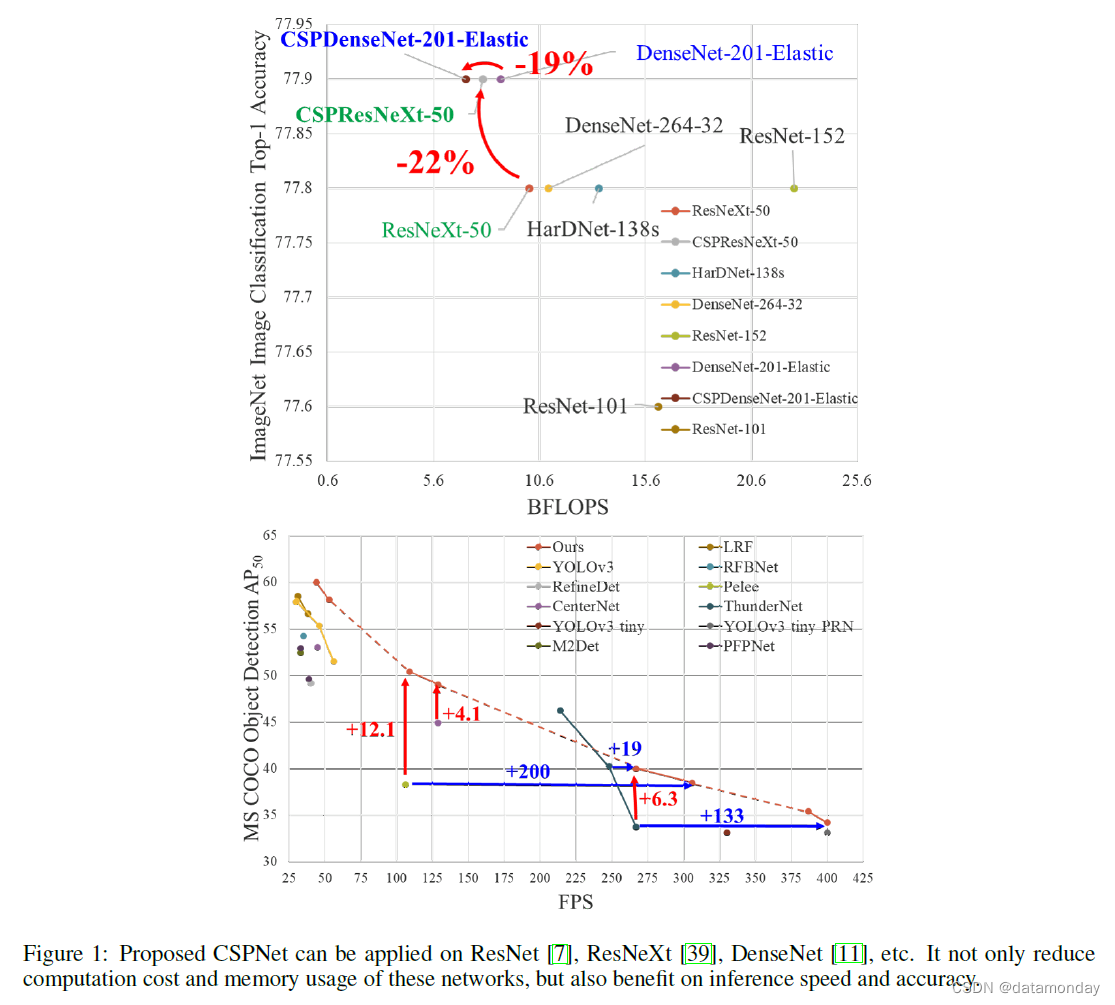

CSPNet在DenseNet网络中的实现如下图（提出该结构的论文是基于DenseNet网络实现的，这里也以DenseNet为例），实际上就是**将Base layer分为两部分，部分1不进行操作，部分2进行Dense Bock和Transition操作变换，然后将两部分特征融合：**
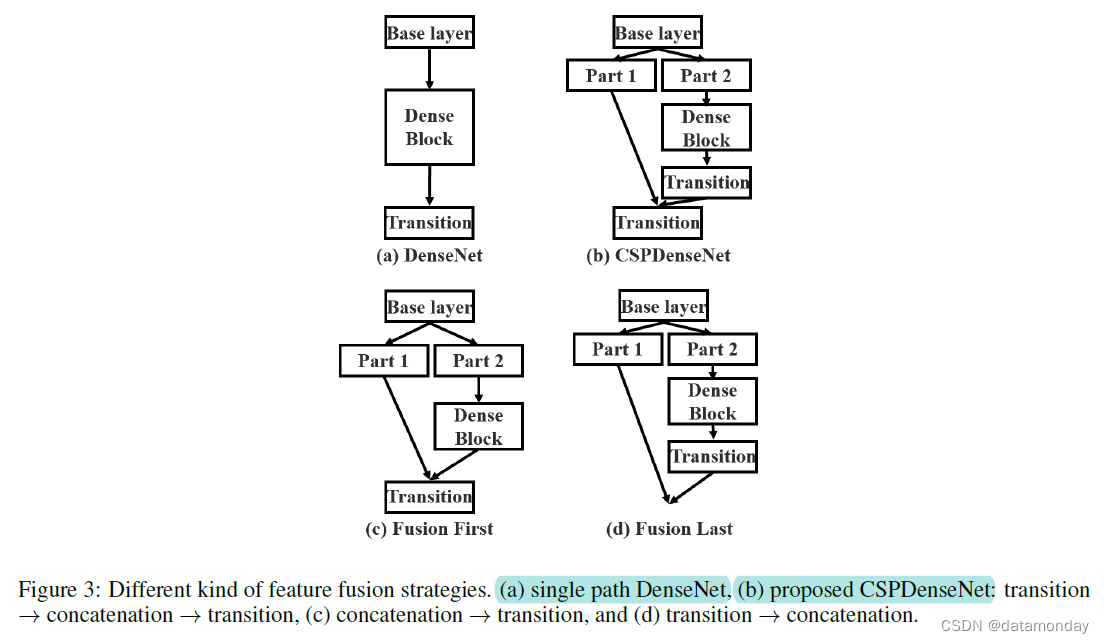

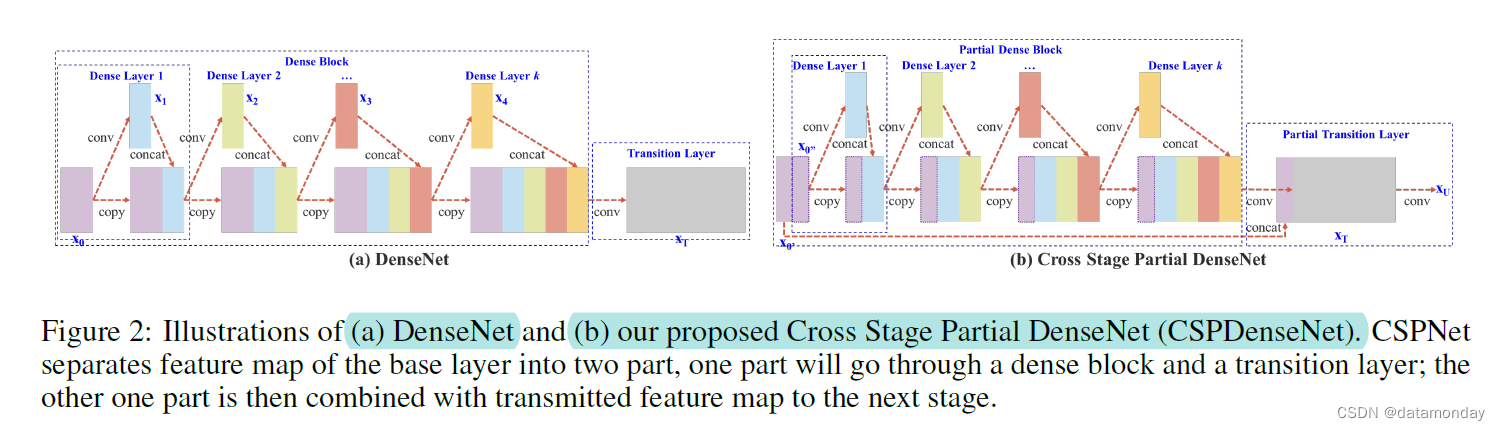
引入了两个模块Partial Dense Layer 和 Partial Transition Layer，如图5(b)。

**直接将输入拆成两部分**

部分密集块的目的有三个：

1）增加梯度路径：通过拆分和合并策略，可以使梯度路径的数量增加一倍。由于跨阶段策略，可以缓解使用显式特征图副本进行连接所带来的缺点；

2）每一层的平衡计算：由于部分稠密块中稠密层操作所涉及的**基层通道只占原始数量的一半**，因此可以有效解决近一半的计算瓶颈；

3）减少内存流量：部分密集块最多可以节省网络一半的内存流量。

部分过渡层的目的是为了最大化梯度组合的差异。部分过渡层是一种分层特征融合机制，它使用截断梯度流的策略来防止不同层学习重复的梯度信息。

### SPP（Spatial Pyramid Pooling）

SPP（Spatial Pyramid Pooling）是为了**确保输入预定义全连接层的feature vector（特征向量）是固定尺寸**。常规做法是在输入数据做文章，即对图像进行裁剪和变形操作。但是这两种方式可能会出现不同的问题，1）裁剪的区域可能没法包含物体的整体；2）变形操作造成目标无用的几何失真。而SPP是**在feature maps展开为feature vector时做文章的**，即SPP将输入的不同图像的feature maps展开为一个固定尺寸的feature vector。以上两种解决问题的思路如下图所示。

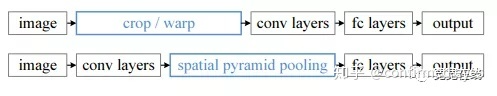

SPP的工作原理很简单，**对每个特征图，使用三种不同尺寸的池化核进行最大池化，分别得到预设的特征图尺寸，最后将所有特征图展开为特征向量并融合**，过程如下图所示。现在，我们以经过5次卷积模块运算后的Tensor[1, 256, 10, 10]为例，运用SPP原理倒推最大池化层的信息。

1）明确全连接层的输入参数尺寸，如107521= 21X256=16X256+4X256+1X256；

2）明确三种池化后的特征图尺寸，如4 * 4、2 * 2、1 * 1；

3）求三种kernel、stride、padding；（是通过规定上面的参数计算出来的）

a. 44对应的kernel、stride、padding：kernel---⌈10/4⌉=3；stride---⌈10/4⌉=3；padding---⌊(34-10+1)/2⌋=1

b. 22对应的kernel、stride、padding：kernel---⌈10/2⌉=5；stride---⌈10/2⌉=5；padding---⌊(52-10+1)/2⌋=0

c. 11对应的kernel、stride、padding：kernel---⌈10/1⌉=10；stride---⌊10/1⌋=10；padding---⌊(101-10+1)/2⌋=0

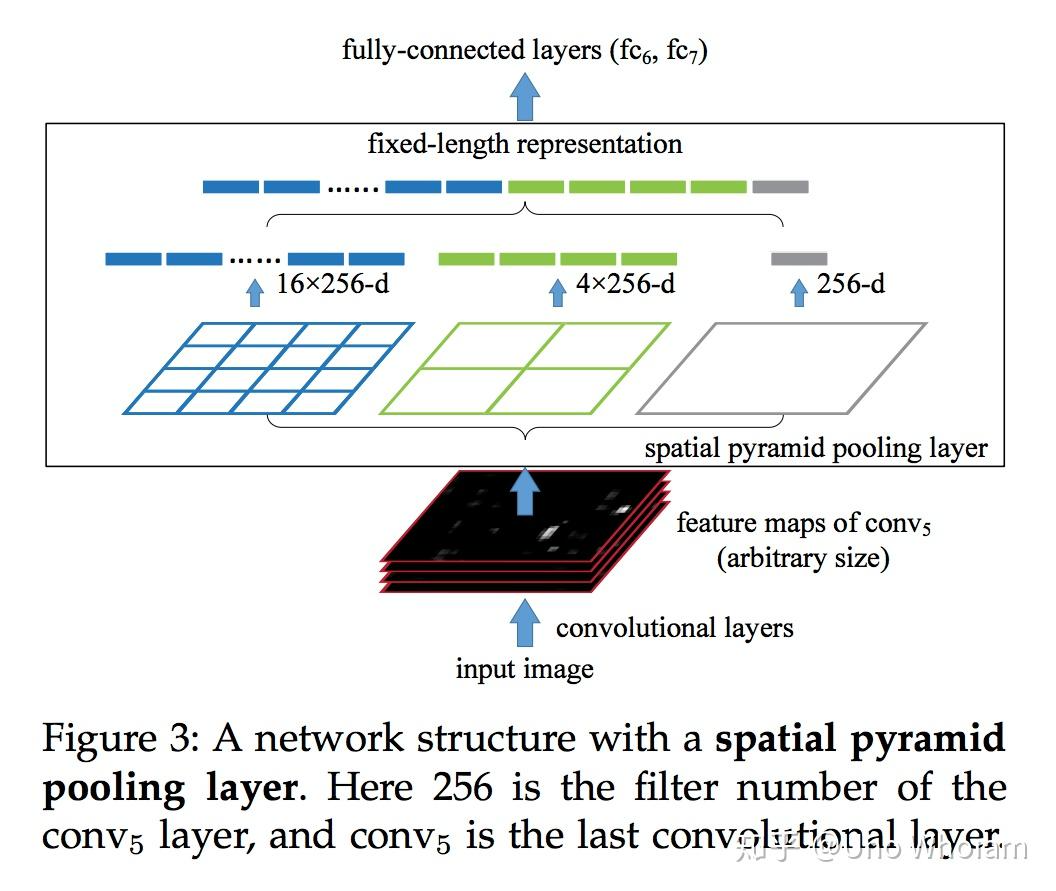

SPP有以下优点

1）可以忽略输入尺寸并且产生固定长度的输出；

2）SPP在**利用不同的池化核尺寸提取特征的方式可以获得丰富的特征信息**，有利于提高网络的识别精度。（这也是在YOLOv5_v6的作用）

### FPN（Feature pyramid network）

FPN（Feature pyramid network）是CVPR2017年的一篇文章，它在目标检测中融入了特征金字塔，提高了目标检测的准确率，尤其体现在**小物体的检测**上。

特征金字塔的高（深）层特征包含有丰富的语义信息（利于分类），但分辨率底，很难准确地保存物体的位置信息；低（浅）层特征虽然语义信息较少，但分辨率高，包含准确的物体位置信息（利于检测和分割）。FPN就是**将低层特征和高层特征融合起来**，得到一个识别和定位都准确的目标检测结构。FPN的结构主要包括三个部分：Bottom-up，Top-down和Lateral connection，如下图所示。

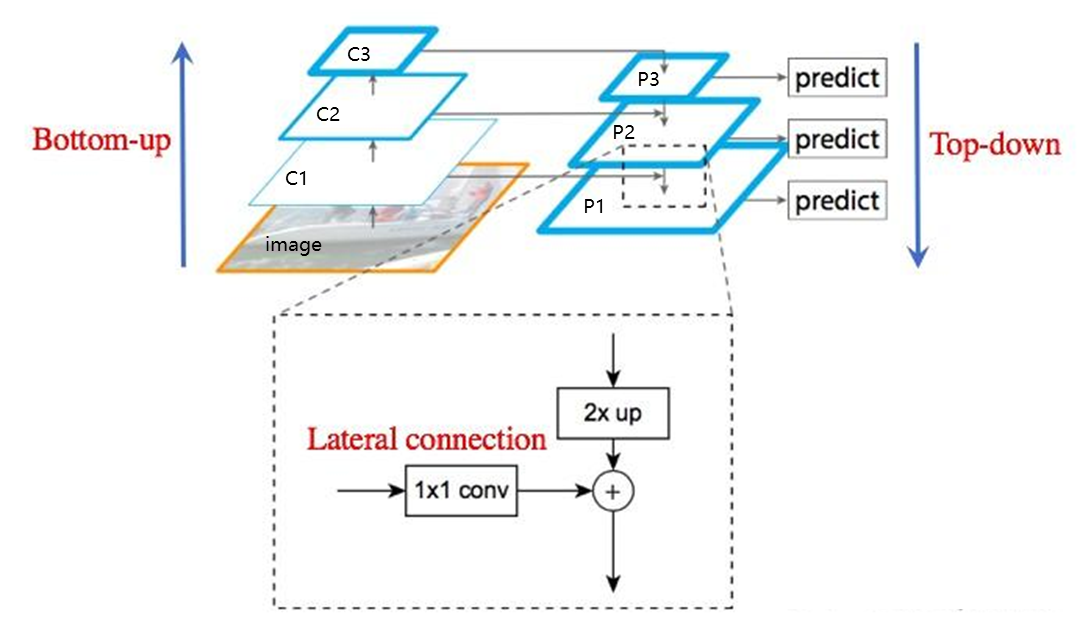

1）Bottom-up：Bottom-up的过程就是将图片输入到backbone中提取特征的过程。

2）Top-down：Top-down的过程就是将高层得到的feature map进行上采样然后往下传递，这样做是因为，高层的特征包含丰富的语义信息，经过top-down的传播就能使得这些语义信息传播到低层特征上，使得低层特征也包含丰富的语义信息。

3）Lateral connection：Lateral connection是一个特征融合的过程，如上图所示，即P1是C1经1*1卷积后的特征与P2上采样后的特征进行融合（add方式）。

### PANet（Path Aggregation Network）

**PANet（Path Aggregation Network）是一个用于实例分割的路径聚合网络，它充分的融合了特征**。PANet总共有5个结构，如下图所示，分别是FPN(a)、Bottom-Up Path Augmentation(b)、Adaptive Feature Pooling(c)、Box branch(d)、Fully-Connected Fusion(e)。

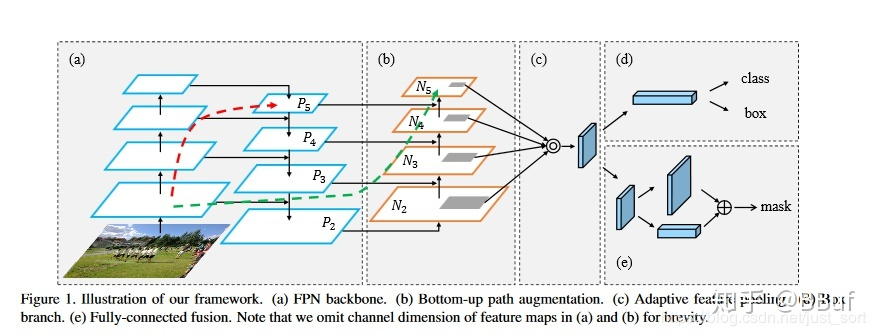

1）FPN上文已经介绍，这里不再赘述。

2）Bottom-Up Path Augmentation：考虑到网络的浅层特征对于实例分割非常重要，FPN虽然已经融合了一次浅层特征，但是仍不能达到很好的分割效果，因此引入Bottom-Up Path Augmentation，以保留更多的浅层特征。它是将N2（N2和P2是同一特征图，因此N2已经包含大量低层特征）进行下采样，下采样后的特征图与P3进行融合，得到N3。因此N3包含的低层特征要多与P3。N4，N5同N3。

**红色的箭头**表示在FPN中，因为要走自底向上的过程，浅层的特征传递到顶层需要经过几十个甚至上百个网络层，当然这取决于BackBone网络用的什么，因此经过这么多层传递之后，浅层的特征信息丢失就会比较严重。

**绿色的箭头**表作者添加了一个Bottom-up Path Augemtation结构，这个结构本身不到10层，这样浅层特征经过原始FPN中的横向连接到P2然后再从P2沿着Bottom-up Path Augemtation传递到顶层，**经过的层数不到10层，能较好的保存浅层特征信息**。注意，这里的N2和P2表示同一个特征图。 但N3,N4,N5和P3,P4,P5不一样，实际上N3,N4,N5是P3,P4,P5融合后的结果。

3）Adaptive Feature Pooling：这一结构做的仍然是特征融合。

YOLOv5_v6使用了PANet中的FPN和Bottom-Up Path Augmentation，因此Box branch、Fully-Connected Fusion不再介绍。读者如想了解其他结构，可参见这里。

Bottom-up Path Augemtation的详细结构如Figure2所示，是一个常规的特征融合操作，这里展示的是Ni经过一个尺寸为3 * 3，步长为2的卷积之后，特征图尺寸减小为原来的一半然后和Pi+1个特征图做add操作，得到的结果再经过一个卷积核尺寸为3 * 3，stride=1的卷积层得到Ni+1。

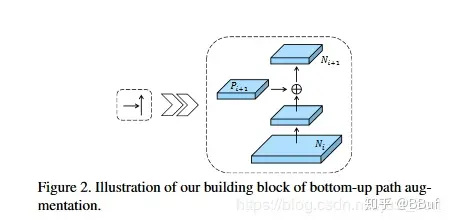

#### Adaptive Feature Pooling

这一结构做的仍然是特征融合。论文指出，**在Faster-RCNN系列的标检测或分割算法中，RPN网络得到的ROI需要经过ROI Pooling或ROI Align提取ROI特征**，这一步操作中每个ROI所基于的特征都是**单层特征**，FPN同样也是基于单层特征，因为检测头是分别接在每个尺度上的。比如ResNet网络中常用的res5的输出。

在引入Adaptive Feature Pooling作者做了Figure3这个实验，可以看到图中有4条不同的曲线，分别对应了FPN网络中的4个特征层，然后每一层都会经过RPN网络获得ROI，因此这4条曲线就对应了4个ROI集合。图像中的横坐标表示的是ROI集合提取的不同层特征的占比。例如蓝色曲线表示level1的特征层，应该是尺度最小的ROI的集合，这一类型的ROI所提取的特征仅有30%是来自level1特征层的特征，剩下的70%均来自level2,3,4。其他level的特征层同理，因此就有了作者的这个思考和改进，也就是说对**每个ROI提取不同层的特征并做融合**，这对于提升模型效果显然是有好处的。
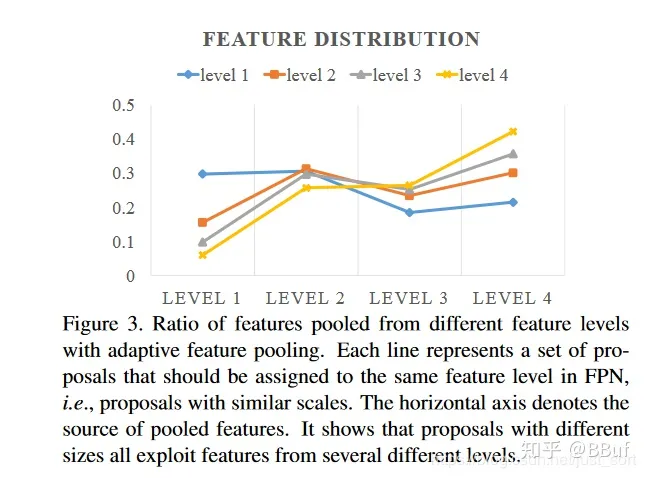

本文提出的Adaptive Feature Pooling则是将单层特征换成多层特征，即每个ROI需要和多层特征（论文中是4层）做ROI Align的操作，然后将得到的**不同层的ROI特征融合**在一起，这样每个ROI特征就融合了**多层特征**。

RPN网络获得的每个ROI都要分别和N2、N3、N4、N5特征层做ROI Align操作，这样个ROI就提取到4个不同的特征图，然后将4个不同的特征图融合在一起就得到最终的特征，后续的分类和回归都是基于此最终的特征进行。

#### Fully-Connected Fusion

PANet最后一个贡献是提出了Fully-connected Fusion，这是对原有的分割支路(FCN)引入一个前景二分类的全连接支路，通过融合这两条支路的输出得到更加精确的分割结果

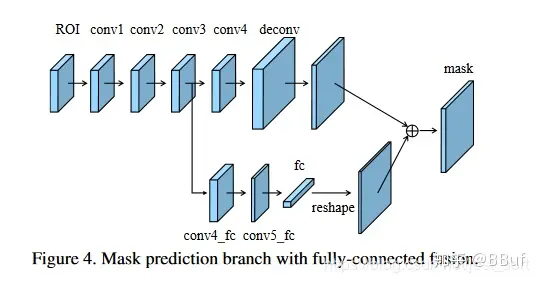

从图中可以看到这个结构主要是在原始的Mask支路（即带deconv那条支路）的基础上增加了下面那个支路做融合。增加的这个支路包含2个3 * 3的卷积层，然后接一个全连接层，再经过reshape操作得到维度和上面支路相同的前背景Mask，即是说下面这个支路做的就是前景和背景的二分类，输出维度类似于文中说的28 * 28 * 1。而上面的支路输出维度类似28 * 28 * K，其中K代表数据集目标类别数。最终，这两条支路的输出Mask做融合以获得更加精细的最终结果。

## 基本原理

YOLOv5的原理和YOLOv1基本是一致的，关于YOLOv1的基本原理见https://www.cnblogs.com/wpx123/p/17640452.html

1）YOLOv5引入了anchor（锚框），实际上从YOLOv2开始就引入了它。没有引入锚框之前，YOLO只能随机初始化边界框，这就导致了基本上几乎所有的初始边界框都不相同、某些框相对于真实框来说差别十分离谱，继而花费了不必要的算力。引入预设的锚框可以大大减少这种花费。

2）单元格预测类别机制更改为了预测该单元格对应边界框内图像的类别，且每个单元格对应三个边界框。

3）网格尺度增加到了三种，可以从小、中、大三个尺度检测目标对象，极大地减少了漏检情况。

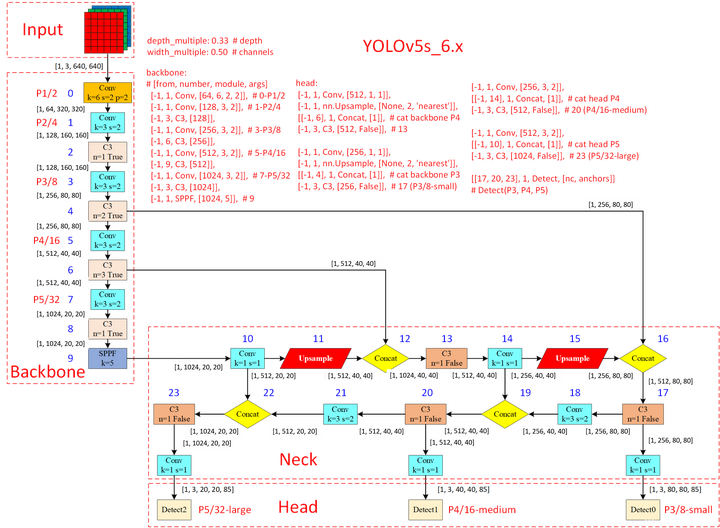


上图可分为两个部分，右上的备注区域及其他区域的网络结构示意。
首先来看网络构架。
1）共分为四块，Input、Backbone、Neck、Head；

2）不同颜色的矩形框代表了不同的基本模块，如Conv、C3、Upsample；

3）Input、Backbone、Neck中的Tensor，[x1, x2, x3, x4]分别是[batch_size, channels, height, width]，即[B, C, H, W]。Head中的Tensor，[x1, x2, x3, x4, x5]分别是[batch_size, bounding_boxs, height, width, A]，A是指边界框的(x, y, w, h, c)与80个类别的概率；

4）Backbone中的Pn1/n2是指第n1次下采样，下采样倍数为n2；

5）Head中的P5/32-large是指此时的每个网格单元是3232像素，网格尺寸是2020，在32*32（大尺度）的单元格基础上绘制边界框。P4/16-medium、P3/8-small同P5/32-large。

其次看一下，备注区域的信息。图片中的信息是来自yolov5.yaml文件，因此我们只需要对yolov5.yaml文件进行解读就可理解图中信息。

```
# Parameters
nc: 80  # 类别数量
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple
"""
depth_multiple：控制子模块的数量
width_multiple：控制卷积核的数量
"""
anchors:
  - [10,13, 16,30, 33,23]  # P3/8，检测小目标，10,13是一组尺寸
  - [30,61, 62,45, 59,119]  # P4/16，检测中目标
  - [116,90, 156,198, 373,326]  # P5/32，检测大目标

# YOLOv5 v6.0 backbone
backbone:
"""
from：输入来自那一层，-1代表上一次，1代表第1层，3代表第3层
number：模块的数量，最终数量需要乘width，然后四舍五入取整，如果小于1，取1
module：子模块
args：模块参数，channel，kernel_size，stride，padding，bias等
"""
  # [from, number, module, args]
  [[-1, 1, Conv, [64, 6, 2, 2]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 6, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 3, C3, [1024]],
   [-1, 1, SPPF, [1024, 5]],  # 9
  ]

# YOLOv5 v6.0 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, C3, [256, False]],  # 17 (P3/8-small)

   [-1, 1, Conv, [256, 3, 2]],
   [[-1, 14], 1, Concat, [1]],  # cat head P4
   [-1, 3, C3, [512, False]],  # 20 (P4/16-medium)

   [-1, 1, Conv, [512, 3, 2]],
   [[-1, 10], 1, Concat, [1]],  # cat head P5
   [-1, 3, C3, [1024, False]],  # 23 (P5/32-large)

   [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
  ]
  
```

### Mosaic数据增强

对应类：datasets.LoadImagesAndLabels()
Mosaic数据增强是指将4张图片随即缩放、随机裁剪、随机排布的方式进行拼接成新的图片，该方式仅在训练过程中使用。下图就是一个Mosaic数据增强的过程。

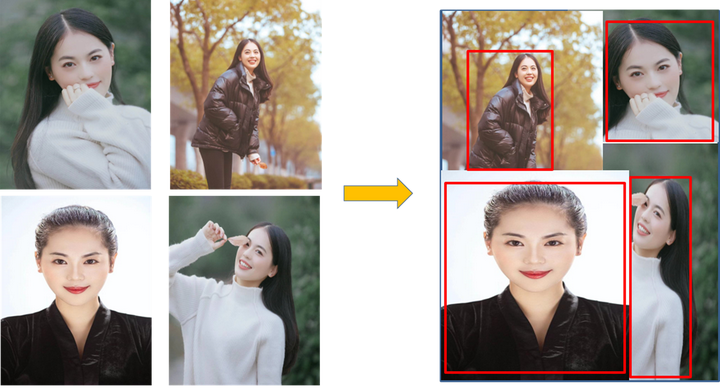

为什么要使用Mosaic数据增强呢？

1）丰富数据集：随机使用4张图片，随机缩放，再随机分布进行拼接，大大丰富了检测数据集，特别是随机缩放增加了很多小目标，让网络的鲁棒性更好。

2）减少GPU：可能会有人说，随机缩放，普通的数据增强也可以做，但作者考虑到很多人可能只有一个GPU，因此Mosaic增强训练时，可以直接计算4张图片的数据，使得Mini-batch大小并不需要很大，一个GPU就可以达到比较好的效果。

### 自适应锚框

对应模块：autoanchor.py

在YOLO算法中针对不同的数据集都会有初始设定长款的锚框，比如YOLOv5s_v6在Coco数据集上初始设定的锚框为：
```
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32
```
在网络训练中，**网络在初始锚框的基础上输出预测框，进而和真实框groundtruth进行比对，计算损失，再反向更新，迭代网络参数**。在Yolov3、Yo1lov4中，训练不同的数据集时，计算初始锚框的值是通过单独的程序运行的。但Yolov5中将此功能嵌入到代码中，每次训练时，自适应的计算不同训练集中的最佳锚框值。

### 自适应图片缩放

对应函数：augmentations.letterbox()

在常用的目标检测算法中，不同的图片长宽都不相同，因此常用的方式是将原始图片统一缩放到一个标准尺寸，再送入检测网络中，如下图所示。但是，在项目实际使用时，很多图片的长宽比不同，因此缩放填充后，两端的黑边大小都不同，而如果填充的比较多，则存在信息冗余，影响推理速度。因此YOLOv5作者在augmentations.letterbox()中对图像自适应添加最少的黑边（代码中添加的是灰边，本文以黑边代替）。

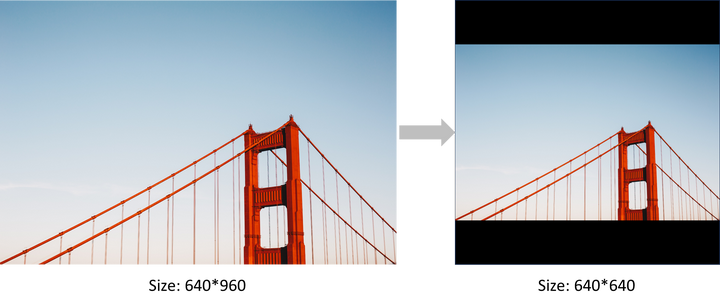



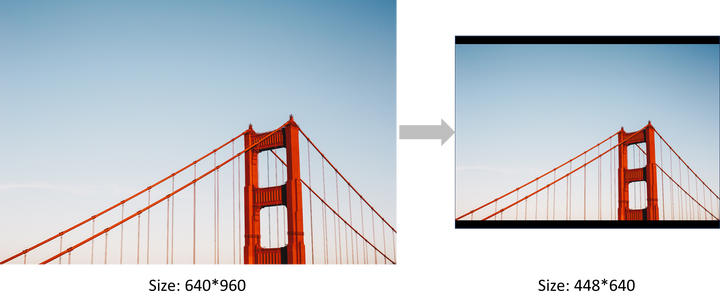

计算过程如下：
1）计算缩放比例：min(640/640, 640/960)-->min(1.0, 0.666)-->0.666

2）计算图片缩放后的尺寸：size=(640 * 0.666)(960 * 0.666)=426 * 640

3）计算黑边填充数值：np.mod(640-426, 32)-->np.mod(214, 32)-->22，即共需填充22行像素黑边，上下个11行。

4）图像的最终尺寸：size=(426+22)640=448640

备注：

1）训练时没有采用缩减黑边的方式，还是采用传统填充的方式，即缩放到640*640大小。只是在测试，使用模型推理时，才采用缩减黑边的方式，提高目标检测，推理的速度。

2）为什么np.mod函数的后面用32？因为Yolov5的网络经过5次下采样，而2的5次方，等于32。所以至少要去掉32的倍数，再进行取余。

### Backbone：Conv、C3、SPPF

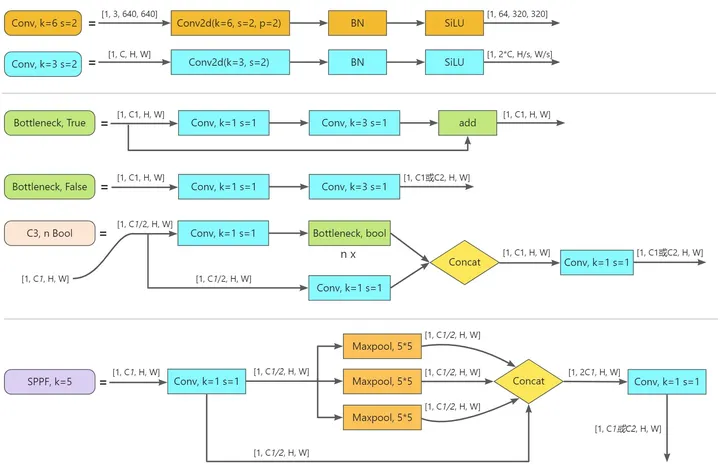

#### Conv

Conv, k=6 s=2，是由2D卷积层+BN层+SiLU激活函数组成的，其目的是减少计算量和参数量，达到提速效果。在YOLOv5_v6之前是使用Focus结构达到的，Conv, k=6 s=2相对于Focus的优点是便于导出其他框架类型的文件。下面让我们看一下Conv, k=6 s=2是如何减少计算量和参数量的，这里我们以一张10 * 10 * 3的图片进行举例。

在剖析之前必须要先知道它是对什么结构的改进，从下图可以看出，它是对Conv, [32, 3, 1]、Conv, [64, 3, 2]、Bottleneck, [64]结构的改进。

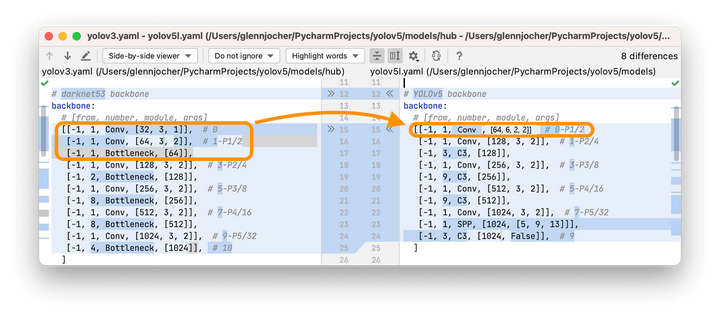

原backbone中的params：(3 * 3 * 3 * 32 + 32) + (32 * 3 * 3 * 64 + 64) + [(64 * 1 * 1 * 64) + 64 + (64 * 3 * 3 * 64) + 64]=60, 480（不考虑bias）

原 backbone中的FLOPs：(3 * 3 * 3 * 32 * 10 * 10)+(32 * 3 * 3 * 64 * 10 * 10) + (64 * 1 * 1 * 64 * 5 * 5 + 64 * 3 * 3 * 64 * 5 * 5)=2, 953, 600（不考虑bias）

YOLOv5_v6 backbone中的params：3 * 6 * 6 * 64 + 64=6, 976（最后一个64是BN层参数，不考虑bias）

YOLOv5_v6 backbone中的FLOPs：3 * 6 * 6 * 64 * 10 * 10=691, 200（不考虑bias）

从上述的计算结果不难看出，Conv, k=6 s=2的确减少了参数量和计算量，而且从实验结果看其效果与darknet53中的差别不大。

Conv, k=3 s=2，k、s是可定义的，在YOLOv5_v6中大都是k=3, s=2和k=1, s=1两种。是由2D卷积层+BN层+SiLU激活函数组成的，可以理解为广义的卷积（因为卷积层后一般都会紧跟BN层、激活函数）。它是YOLO中最基本的结构单元，参与构成其他结构，如Bottleneck、C3、SPPF等。

#### C3
Bottleneck

Bottleneck用于减少计算量和参数量，与Bottleneck等效的普通卷积计算量和参数量高于Bottleneck。带有短路的Bottleneck还具有丰富特征语义信息的作用。

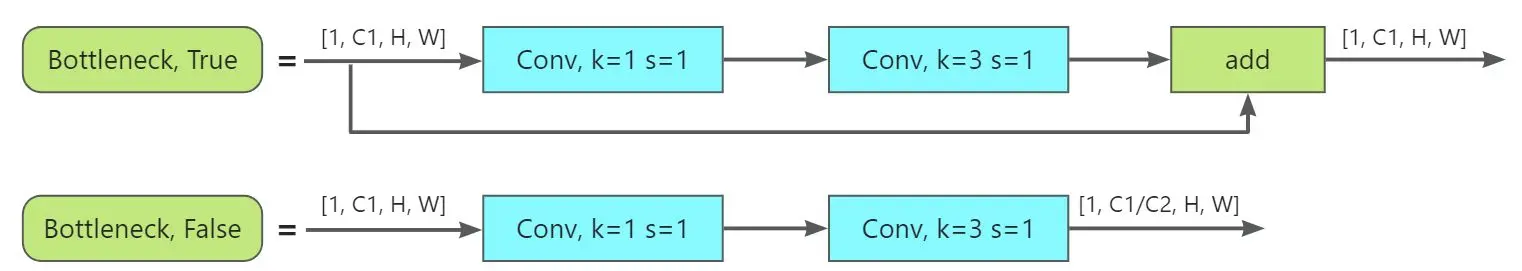

```
class Bottleneck(nn.Module):
    # 标准bottleneck
    def __init__(self, c1, c2, shortcut=True, g=1, e=0.5):  # ch_in, ch_out, shortcut, groups, expansion
        super().__init__()
        c_ = int(c2 * e)  # 隐藏层
        self.cv1 = Conv(c1, c_, 1, 1)
        self.cv2 = Conv(c_, c2, 3, 1, g=g)
        self.add = shortcut and c1 == c2

    def forward(self, x):
        return x + self.cv2(self.cv1(x)) if self.add else self.cv2(self.cv1(x))
```
YOLOv5_v6中还存在BottleneckCSP、GhostBottleneck变体，它们都在common.py中。Bottlenect减少了参数量和计算量，具体减少了多少和c1、c2、e都有关系，其计算方式前面已经介绍，这里不再赘述。


C3（CSP Bottleneck with 3 convolutions）

C3可以增强CNN的学习能力，使网络轻量化的同时提升准确度。

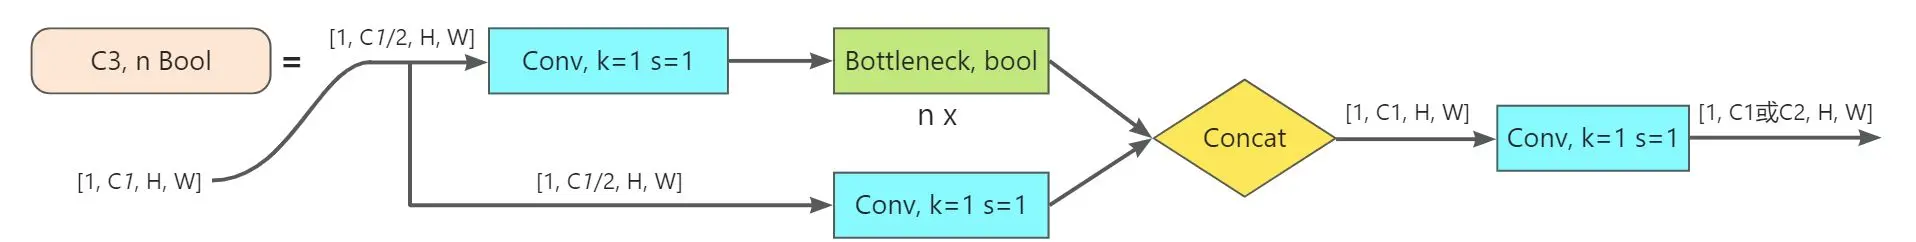

```
class C3(nn.Module):
    # CSP Bottleneck with 3 convolutions
    def __init__(self, c1, c2, n=1, shortcut=True, g=1, e=0.5):  # ch_in, ch_out, number, shortcut, groups, expansion
        super().__init__()
        c_ = int(c2 * e)  # hidden channels
        self.cv1 = Conv(c1, c_, 1, 1)
        self.cv2 = Conv(c1, c_, 1, 1)
        self.cv3 = Conv(2 * c_, c2, 1)  # act=FReLU(c2)
        self.m = nn.Sequential(*[Bottleneck(c_, c_, shortcut, g, e=1.0) for _ in range(n)])
        # self.m = nn.Sequential(*[CrossConv(c_, c_, 3, 1, g, 1.0, shortcut) for _ in range(n)])

    def forward(self, x):
        return self.cv3(torch.cat((self.m(self.cv1(x)), self.cv2(x)), dim=1))
```
C3借鉴了CSPNet处理思想，利用n个Bottleneck、3个卷积模块、Concat来实现。C3减少了梯度信息的重复，这极大地减小了计算量，同时也使准确率有所提升。总结来说就是它增强了backbone的学习能力、消除了计算瓶颈、降低了内存成本。它与CSPNet相比更简单、更迅速、融合性更好，且对CNN网络学习能力的增强基本一致。

#### SPPF

SPPF顾名思义，就是为了保证准确率相似的条件下，减少计算量，以提高速度，使用3个5×5的最大池化，代替原来v6之前的5×5、9×9、13×13最大池化。使用SPPF的目的是为了利用不同的池化核尺寸提取特征的方式可以获得更多的特征信息，提高网络的识别精度。
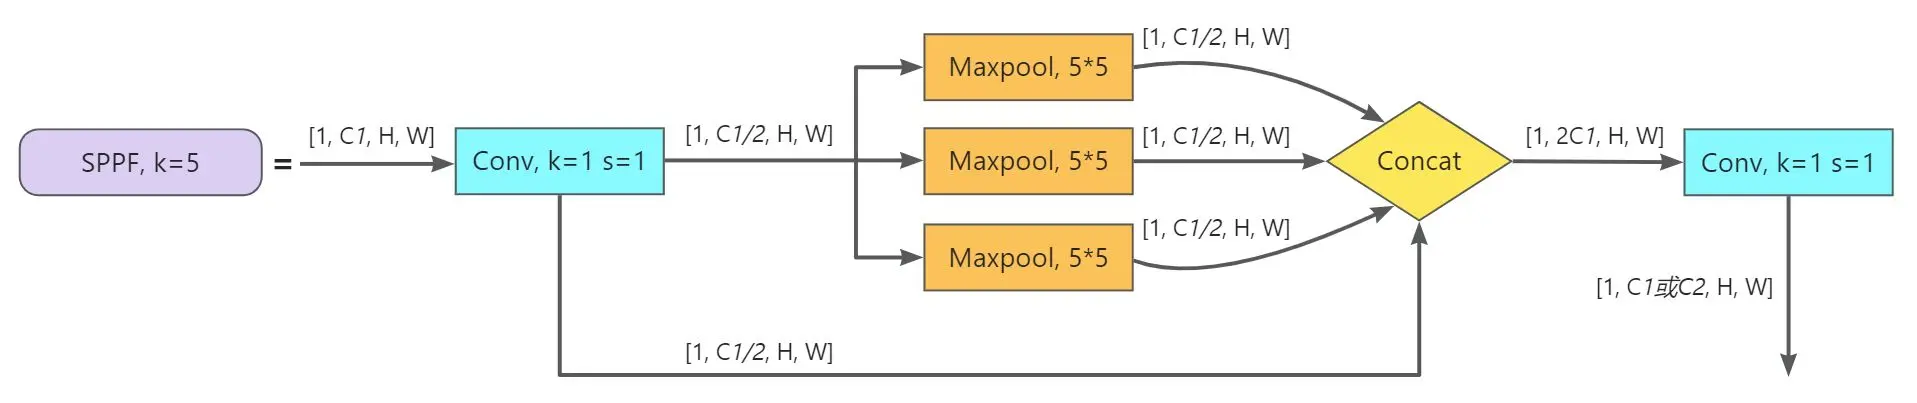

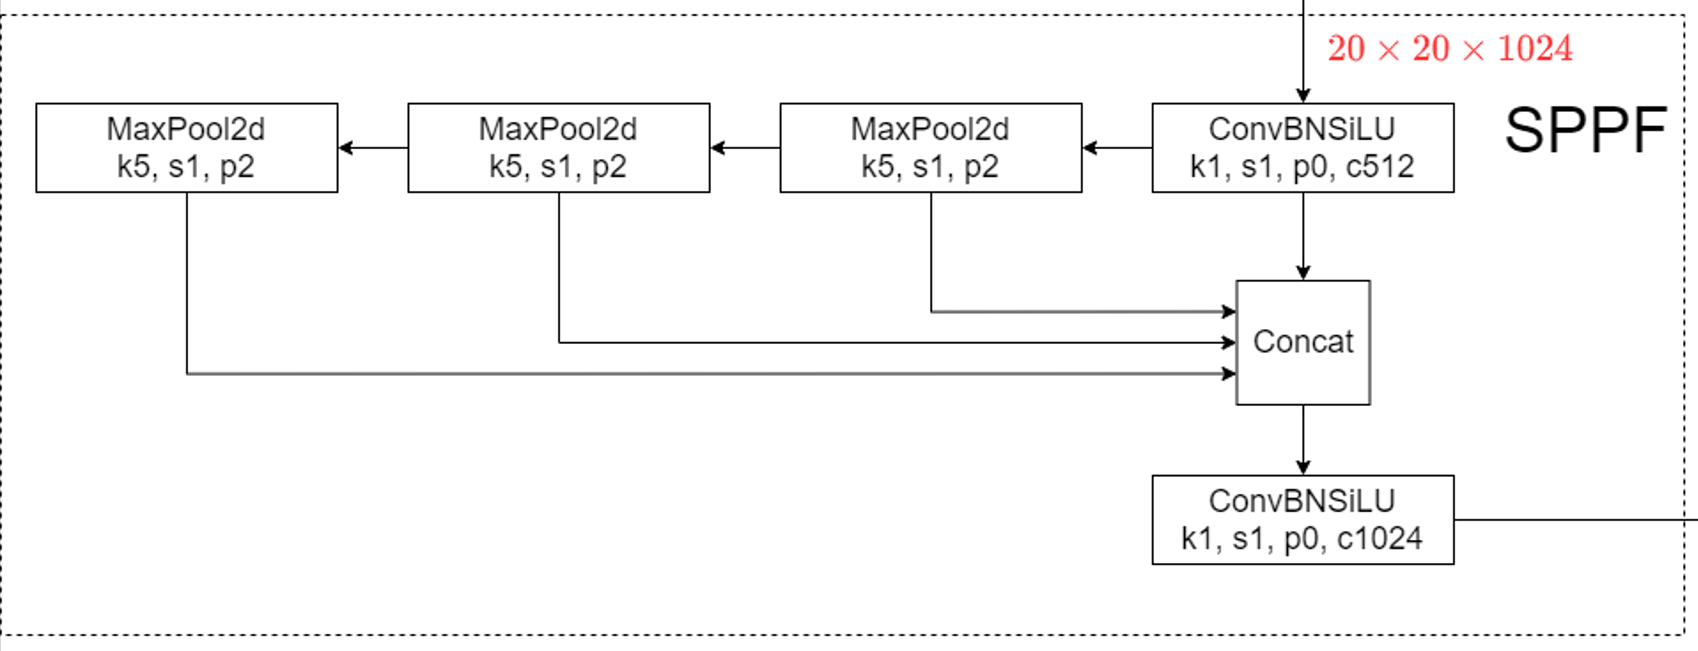

```
class SPPF(nn.Module):
    # Spatial Pyramid Pooling - Fast (SPPF) layer for YOLOv5 by Glenn Jocher
    def __init__(self, c1, c2, k=5):  # equivalent to SPP(k=(5, 9, 13))
        super().__init__()
        c_ = c1 // 2  # hidden channels
        self.cv1 = Conv(c1, c_, 1, 1)
        self.cv2 = Conv(c_ * 4, c2, 1, 1)
        self.m = nn.MaxPool2d(kernel_size=k, stride=1, padding=k // 2)

    def forward(self, x):
        x = self.cv1(x)
        with warnings.catch_warnings():
            warnings.simplefilter('ignore')  # suppress torch 1.9.0 max_pool2d() warning
            y1 = self.m(x)
            y2 = self.m(y1)
            return self.cv2(torch.cat([x, y1, y2, self.m(y2)], 1))
```

#### Neck
这一部分不能单独进行理解，需要和backbone结合在一起进行理解，Neck和Backbone结合在一起就是PANet中的FPN+Bottom-Up Path Augmentation结构，其目的就是将深层特征的语义信息和浅层特征在三种尺度的特征图中进行充分融合，使其更利于进行目标检测。

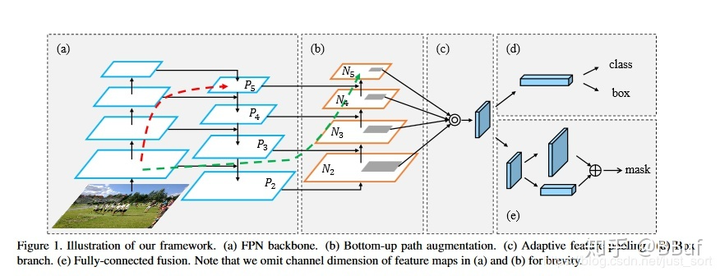

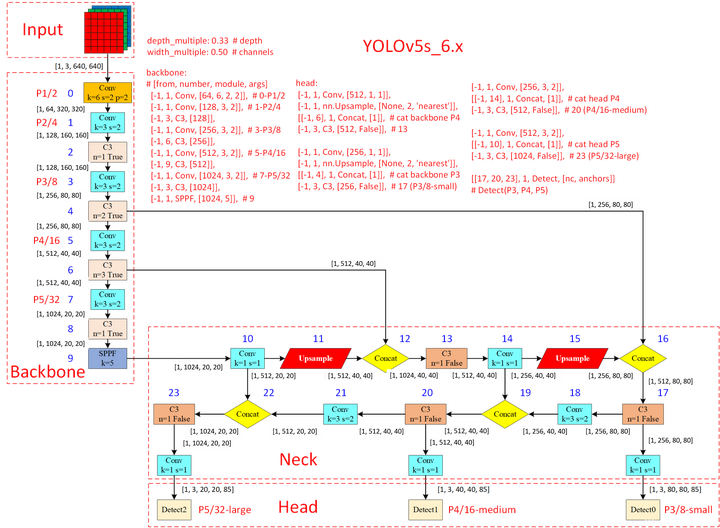